In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error

In [8]:
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device name:", torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device: ",device)

num_cores = os.cpu_count()
print("Number of cores: ",num_cores)

PyTorch version: 2.5.1+cu118
CUDA available: True
Device name: NVIDIA GeForce GTX 1650 Ti
Device:  cuda
Number of cores:  12


In [3]:
garstec_data = r'C:\Users\kiena\Documents\YEAR 4\PROJECT\Data\Garstec_AS09_chiara.hdf5'

# 7 Inputs
ages = []
massini = []
fehini = []
alphamlt = []
yini = []
eta = []
alphafe = []

# 8 Outputs
teff = []
luminosity = []
dnufit = []
FeH = []
G_GAIA = []
massfin = []
numax = []
MeH = []

# Open the hdf5 file (read-only mode)
with h5py.File(garstec_data, 'r') as hdf:

    grid = hdf['grid']
    tracks = grid['tracks']

    # Get a list of track names and shuffle for random sampling
    track_names = list(tracks.keys())
    random.seed(1)
    random.shuffle(track_names)

    # Choose a subset of tracks to process
    num_tracks = 1000  # Set the number of tracks to process
    selected_tracks = track_names[:num_tracks]

    for track_name in selected_tracks:  # Iterate over the selected track names
        track = tracks[track_name]
        
        # Inputs
        ages.append(track['age'][:])
        massini.append(track['massini'][:])
        fehini.append(track['FeHini'][:])
        alphamlt.append(track['alphaMLT'][:])
        yini.append(track['yini'][:])
        eta.append(track['eta'][:])
        alphafe.append(track['alphaFe'][:])

        # Outputs
        teff.append(track['Teff'][:])
        luminosity.append(track['LPhot'][:])
        dnufit.append(track['dnufit'][:])
        FeH.append(track['FeH'][:])
        G_GAIA.append(track['G_GAIA'][:])
        massfin.append(track['massfin'][:])
        numax.append(track['numax'][:])
        MeH.append(track['MeH'][:])

# Convert lists to numpy arrays and concatenate them (make one big list)

# Define a small constant to avoid log10(0)
epsilon = 1e-10

# Features requiring log10 transformation
log10_vars_inputs = [ages, massini, alphamlt, eta, yini]

# Transform log10 variables
log10_transformed_inputs = [np.log10(np.maximum(np.concatenate(var).reshape(-1, 1), epsilon)) for var in log10_vars_inputs]

# Concatenate all inputs, including raw `fehini` and `yini`
inputs = np.hstack(log10_transformed_inputs + [np.concatenate(fehini).reshape(-1, 1), 
                                               np.concatenate(alphafe).reshape(-1, 1)])

# Features requiring log10 transformation (strictly positive outputs)
log10_vars_outputs = [teff, luminosity, dnufit, massfin, numax]

# Transform log10 variables
log10_transformed_outputs = [np.log10(np.maximum(np.concatenate(var).reshape(-1, 1), epsilon)) for var in log10_vars_outputs]

# Combine transformed log10 outputs with raw FeH and MeH
# FeH and MeH are not transformed, concatenated directly
outputs = np.hstack(log10_transformed_outputs + [np.concatenate(FeH).reshape(-1, 1), 
                                                 np.concatenate(MeH).reshape(-1, 1),
                                                 np.concatenate(G_GAIA).reshape(-1, 1)])



In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, random_state=1)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Convert data to PyTorch tensors and move to gpu
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=2**14, shuffle=True)  


cuda


In [5]:
# Define the neural network
class GarstecNet(nn.Module):
    def __init__(self):
        super(GarstecNet, self).__init__()
        self.dense1 = nn.Linear(7, 64)   # Input layer
        self.dense2 = nn.Linear(64, 64)
        self.dense3 = nn.Linear(64, 64)  
        self.dense4 = nn.Linear(64, 64)
        self.dense5 = nn.Linear(64, 64)
        self.dense6 = nn.Linear(64, 8)    # Output layer
        

    def forward(self, x):
        x = torch.relu(self.dense1(x))
        x = torch.relu(self.dense2(x))
        x = torch.relu(self.dense3(x))  
        x = torch.relu(self.dense4(x))
        x = torch.relu(self.dense5(x))
        x = self.dense6(x)
        return x


# Instantiate model, loss function, and optimizer
model = GarstecNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Lists to store loss for plotting
train_losses = []
test_losses = []

epochs = 5
best_test_loss = float('inf')  # Initialize with infinity, so any loss will be better initially
best_model_wts = None  # Variable to store the best model's weights
best_epoch = -1 # Variable to store epoch of best model

save_dir = r'C:\Users\kiena\Python Project\Year4Project\dev\GarstecModel_V4'
os.makedirs(save_dir, exist_ok=True)  # Create directory if it doesn't exist

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=250, gamma=0.85)

for epoch in range(epochs):

    model.train()  # Set model to training mode
    epoch_train_loss = 0  # Accumulator for training loss
    
    for batch_X, batch_y in dataloader:     # Iterate over DataLoader batches
        
        # Move to GPU
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()    # Clear gradients
        predictions = model(batch_X)    # Forward pass

        loss = criterion(predictions, batch_y)    # Compute loss
        loss.backward()   # Backward pass
        optimizer.step()     # Update weights
        
        epoch_train_loss += loss.item()      # Add batch loss to epoch loss
    
    epoch_train_loss /= len(dataloader)      # Average training loss
    train_losses.append(epoch_train_loss)       # Store training loss
    
    # Testing phase
    model.eval()    # Set model to evaluation mode
    epoch_test_loss = 0      # Accumulator for test loss
    
    with torch.no_grad():   # Disable gradient computation for testing
        
        X_test_tensor = X_test_tensor.to(device)
        y_test_tensor = y_test_tensor.to(device)

        test_predictions = model(X_test_tensor)      # Forward pass for test set
        epoch_test_loss = criterion(test_predictions, y_test_tensor).item()     # Compute loss
        test_losses.append(epoch_test_loss)      # Store test loss
    

    # Check if the current test loss is the best (lowest)
    if epoch_test_loss < best_test_loss:
        best_test_loss = epoch_test_loss
        best_model_wts = model.state_dict()  # Save the best model's weights
        best_epoch = epoch + 1

    # Step the scheduler
    scheduler.step()

    # Print progress
    if (epoch+1) % 1 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

# Training complete
# Save the overall best model at the end of the training loop (after all epochs)
if best_model_wts is not None:
    # Save the best model's weights and optimizer state at the end of training
    torch.save({
        'epoch': epochs,  
        'model_state_dict': best_model_wts,
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': best_test_loss,
    }, os.path.join(save_dir, 'best_model.pth'))  # Save model checkpoint

    print(f"Best model saved to {os.path.join(save_dir, 'best_model.pth')}, epoch: {best_epoch}, test loss: {best_test_loss}")


Epoch 1/5, Train Loss: 0.4978, Test Loss: 0.4896, LR: 0.010000
Epoch 2/5, Train Loss: 0.5051, Test Loss: 0.4944, LR: 0.010000
Epoch 3/5, Train Loss: 0.4898, Test Loss: 0.4993, LR: 0.010000
Epoch 4/5, Train Loss: 0.5192, Test Loss: 0.5041, LR: 0.010000
Epoch 5/5, Train Loss: 0.5031, Test Loss: 0.4982, LR: 0.010000
Best model saved to C:\Users\kiena\Python Project\Year4Project\dev\GarstecModel_V4\best_model.pth, epoch: 0, test loss: 0.4895944595336914


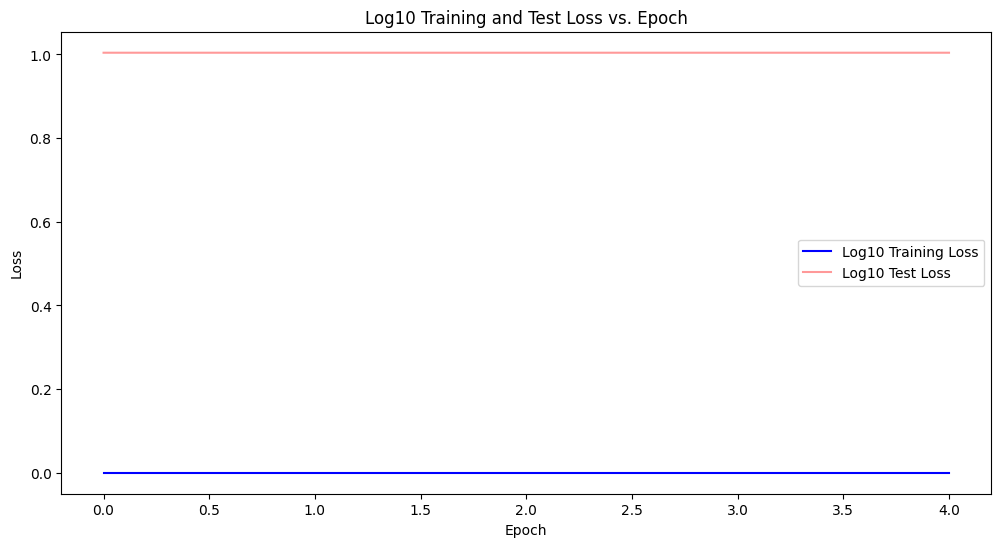

In [8]:
# Plotting the training and test loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Log10 Training Loss', color='blue')
plt.plot(test_losses, label='Log10 Test Loss', color='red', alpha=0.4)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Log10 Training and Test Loss vs. Epoch')
plt.legend()
plt.show()

In [9]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    
    # Move predictions to CPU and convert to numpy
    predictions = predictions.cpu().numpy()
    
    # Inverse transform the predictions and actual values
    predictions = scaler_y.inverse_transform(predictions)
    y_test_actual = scaler_y.inverse_transform(y_test_tensor.cpu().numpy())

    # Calculate evaluation metrics
    r2 = r2_score(y_test_actual, predictions)
    mae = mean_absolute_error(y_test_actual, predictions)

    print(f'R^2 Score: {r2:.4f}')
    print(f'Mean Absolute Error: {mae:.4f}')


R^2 Score: -0.0066
Mean Absolute Error: 0.7722


In [10]:
random.seed(1)

# Select a random track (seed ensures its the same as training set)
selected_tracks = track_names[:1000]  

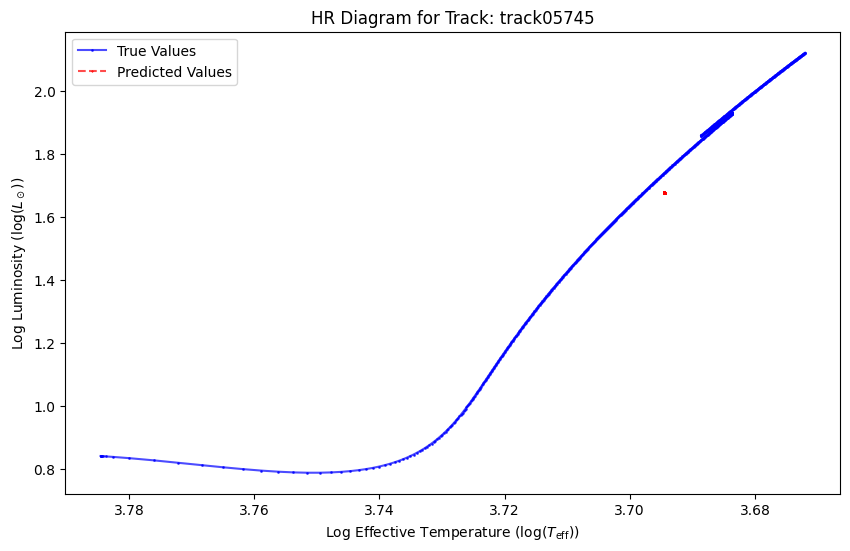

In [16]:
# Select random track from the same 10000 that we trained the NN on
specific_track_name = random.choice(selected_tracks)

# Retrieve all required inputs for the specific track
with h5py.File(garstec_data, 'r') as hdf:
    specific_track = hdf['grid']['tracks'][specific_track_name]

    ages = specific_track['age'][:].reshape(-1, 1)
    massini = specific_track['massini'][:].reshape(-1, 1)
    fehini = specific_track['FeHini'][:].reshape(-1, 1)
    alphamlt = specific_track['alphaMLT'][:].reshape(-1, 1)
    yini = specific_track['yini'][:].reshape(-1, 1)
    eta = specific_track['eta'][:].reshape(-1, 1)
    alphafe = specific_track['alphaFe'][:].reshape(-1, 1)

    # Combine features into a single array
    all_features = np.hstack((ages, massini, fehini, alphamlt, yini, eta, alphafe))

    # Retrieve actual values for plotting
    teff_specific = specific_track['Teff'][:]
    luminosity_specific = specific_track['LPhot'][:]

# Combine inputs and apply log10 transformations where required
epsilon = 1e-10
log10_vars_inputs = [ages, massini, alphamlt, eta, alphafe]
log10_transformed_inputs = [np.log10(np.maximum(var, epsilon)) for var in log10_vars_inputs]

# Combine log-transformed inputs with raw `fehini` and `yini`
all_features = np.hstack(log10_transformed_inputs + [fehini, yini])

# Scale the input features
all_features_scaled = scaler_X.transform(all_features)

# Convert scaled inputs to PyTorch tensor
all_features_tensor = torch.FloatTensor(all_features_scaled).to(device)

# Put the model in evaluation mode and make predictions
model.eval()
with torch.no_grad():
    predictions_specific = model(all_features_tensor).cpu().numpy()
    predictions_specific = scaler_y.inverse_transform(predictions_specific)

# Extract predicted `Teff` and `Luminosity`
predicted_teff = 10**predictions_specific[:, 0]  # Inverse log10 transformation
predicted_luminosity = 10**predictions_specific[:, 1]

# Log-transform true values for plotting
log_actual_teff = np.log10(teff_specific)
log_actual_luminosity = np.log10(luminosity_specific)

# Log-transform predicted values for plotting
log_predicted_teff = np.log10(predicted_teff)
log_predicted_luminosity = np.log10(predicted_luminosity)

# Plot HR Diagram for the selected track
plt.figure(figsize=(10, 6))
plt.plot(log_actual_teff, log_actual_luminosity, label='True Values', color='blue', marker='o', markersize=1, linestyle='-', alpha=0.7)
plt.plot(log_predicted_teff, log_predicted_luminosity, label='Predicted Values', color='red', marker='x', markersize=1, linestyle='--', alpha=0.7)
plt.gca().invert_xaxis()  # Effective temperature is plotted in reverse
plt.xlabel("Log Effective Temperature ($\log(T_\mathrm{eff})$)")
plt.ylabel("Log Luminosity ($\log(L_\odot)$)")
plt.title(f"HR Diagram for Track: {specific_track_name}")
plt.legend()
plt.show()

